In [1]:
import numpy as np
from naivebayes import NaiveBayes
from regression import MulticlassLogistic
from matplotlib import pyplot as plt
from matplotlib import cm

%load_ext autoreload
%autoreload 2

## Generate Sample Test Data

In [2]:

def generate_gaussian_data(covs, means, classes, beta=0.1, size=100):
    """ covs: list of covariance matrices
        means: list of means 
        beta: float [0, 1), rate is the probability of generating outliers in gaussian distributed clusters
    """
    assert len(means) == len(classes), "Make sure class labels match dimensions of mean/ cov"
    X = []
    y = []
    K = len(classes)
    outlier_rate = beta / (K - 1)
    main_rate = 1 - beta
    func = lambda x, y: main_rate if x == y else outlier_rate
    for k in range(K):
        X.append(np.random.multivariate_normal(means[k], covs[k], size=(size)))
        y.append(np.random.choice(classes, size=size, p=[func(i, k) for i in range(K)]))
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y

def generate_random_data(xys, centers, classes, beta=0.1, size=100):
    """ generate uniform distributed dataset
        xys: list of x and y ranges
        centers: list of centers 
    """
    assert len(means) == len(classes), "Make sure class labels match dimensions of mean/ cov"
    X = []
    y = []
    K = len(classes)
    outlier_rate = beta / (K - 1)
    main_rate = 1 - beta
    func = lambda x, y: main_rate if x == y else outlier_rate
    for k in range(K):
        x_range, y_range = xys[k]
        center_x, center_y = centers[k]
        X.append(np.c_[(np.random.rand(size) - 0.5) * x_range + center_x, (np.random.rand(size) - 0.5) * y_range + center_y])
        y.append(np.random.choice(classes, size=size, p=[func(i, k) for i in range(K)]))
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y

np.random.seed(9)
classes = [2, 1, 3]
means = [[0, 0], [5, 5], [10, 10]]
covs = [[[1, 0], [0, 1]] for _ in range(3)]
X, y = generate_gaussian_data(covs, means, classes, beta=0.05)
# for class_ in classes:
#     plt.scatter(X[y==class_, 0], X[y==class_, 1])

## Fit Classifiers

In [4]:
lg_ovr_model = MulticlassLogistic(scheme="ovr")
lg_ovr_model.fit(X, y)
y_pred = lg_ovr_model.predict(X)
print("Ovr Logistic Accuracy = %f" % (np.sum(y_pred == y) / len(y)))

lg_multi_model = MulticlassLogistic(scheme="multinomial")
lg_multi_model.fit(X, y)
y_pred = lg_multi_model.predict(X)
print("Multinorm Logistic Accuracy = %f" % (np.sum(y_pred == y) / len(y)))

nb_model = NaiveBayes()
nb_model.fit(X, y)
y_pred = nb_model.predict(X)
print("Naive Bayes Accuracy = %f" % (np.sum(y_pred == y) / len(y)))

Ovr Logistic Accuracy = 0.913333
Multinorm Logistic Accuracy = 0.936667
Naive Bayes Accuracy = 0.943333


In [5]:
def contour_plot(model, X_train, y_train, box=[-5, 15]):
    y_pred = model.predict(X_train)

    delta = 0.1
    x_grid = np.arange(box[0] - delta, box[1] + delta, delta)
    y_grid = np.arange(box[0] - delta, box[1] + delta, delta)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    r, c = X_grid.shape
    Xy_grid = np.stack((X_grid.reshape(-1), Y_grid.reshape(-1)), axis=-1)

    probs = model._predict_prob(Xy_grid)
    preds = np.argmax(probs, axis=-1)
    pred_grid = preds.reshape(r, c)
    # print("Largest prob:", np.max(probs))
    Z_grid = np.take_along_axis(probs, preds[:, np.newaxis], axis=1).reshape(r, c)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    cntrs = []

    colors=["Greens", "Oranges", "Blues"]
    scolors = ["g", "r", "b"]
    for i, class_ in enumerate(model._class):
        masked_Z = np.ma.array(Z_grid, mask = (pred_grid!=i))
        cntrs.append(ax.contourf(X_grid, Y_grid, masked_Z, cmap=plt.get_cmap(colors[i])))
        cax = fig.add_axes([ax.get_position().x1 + 0.02 + 0.08*i, ax.get_position().y0, 0.02, ax.get_position().height])
        fig.colorbar(cntrs[i], cax=cax)
    for i, class_ in enumerate(model._class):
        ax.scatter(X_train[y_train==class_, 0], X_train[y_train==class_, 1], c=scolors[i], lw=1, edgecolors='black', label="Class %i" % class_)
    ax.legend()
    return fig, ax


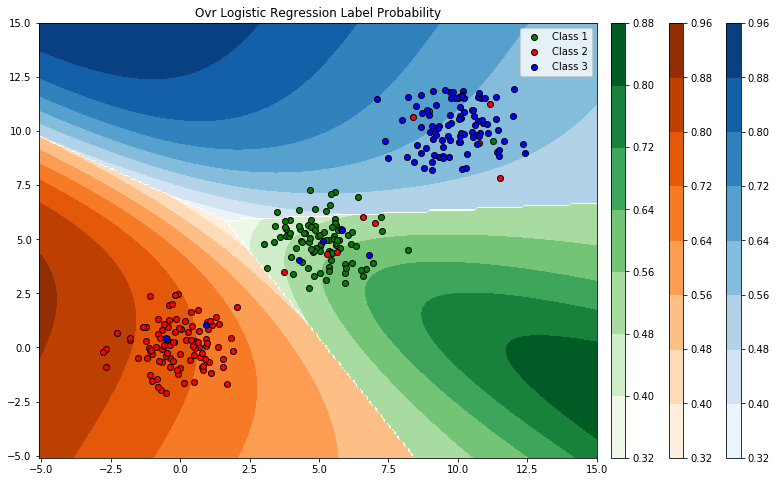

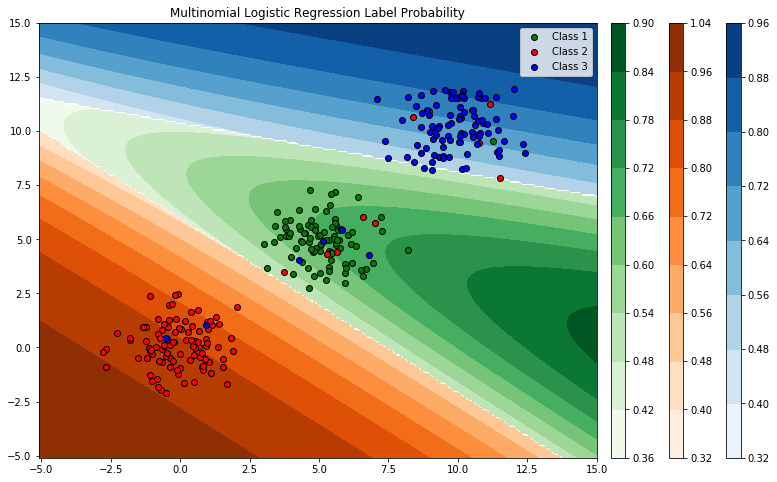

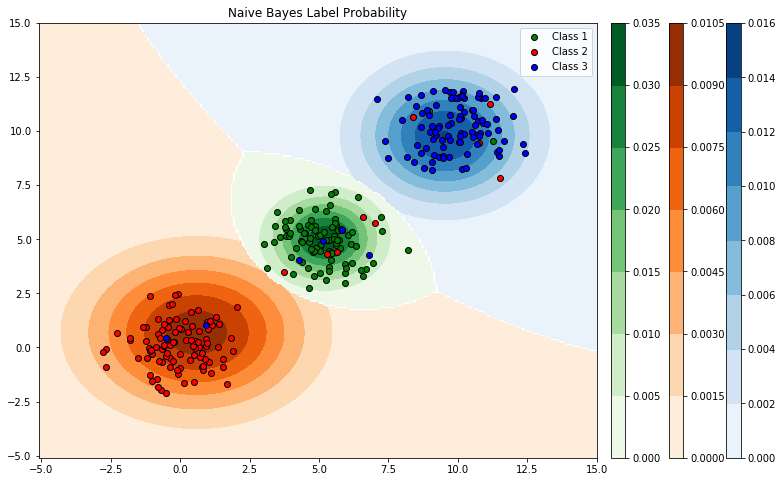

In [7]:
fig1, ax1 = contour_plot(lg_ovr_model, X, y)
ax1.set_title("Ovr Logistic Regression Label Probability")
plt.savefig("./gaussian_log_ovr.png", )

fig2, ax2 = contour_plot(lg_multi_model, X, y)
ax2.set_title("Multinomial Logistic Regression Label Probability")
plt.savefig("./gaussian_log_multi.png")

fig3, ax3 = contour_plot(nb_model, X, y)
ax3.set_title("Naive Bayes Label Probability")
plt.savefig("./gaussian_naive.png")
plt.show()


## Less Conditional Independence

In [9]:
classes = [2, 1, 3]
centers = [[-5, 0], [0, 0], [5, 0]]
xys = [[5, 17], [5, 17], [5, 17]]
X, y = generate_random_data (xys, centers, classes, beta=0.05)

lg_ovr_model = MulticlassLogistic(scheme="ovr")
lg_ovr_model.fit(X, y, max_epoch=300)
y_pred = lg_ovr_model.predict(X)
print("Ovr Logistic Accuracy = %f" % (np.sum(y_pred == y) / len(y)))

lg_multi_model = MulticlassLogistic(scheme="multinomial")
lg_multi_model.fit(X, y, max_epoch=300)
y_pred = lg_multi_model.predict(X)
print("Multinomial Logistic Accuracy = %f" % (np.sum(y_pred == y) / len(y)))

nb_model = NaiveBayes()
nb_model.fit(X, y)
y_pred = nb_model.predict(X)
print("Naive Bayes Accuracy = %f" % (np.sum(y_pred == y) / len(y)))

Ovr Logistic Accuracy = 0.836667
Multinomial Logistic Accuracy = 0.906667
Naive Bayes Accuracy = 0.910000


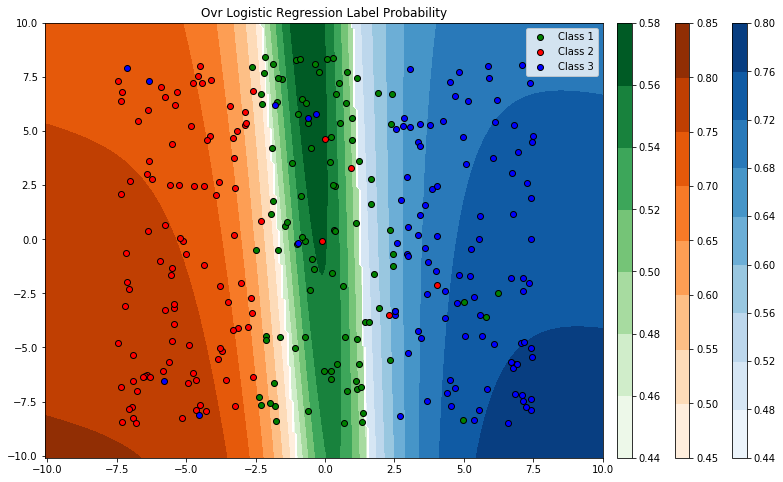

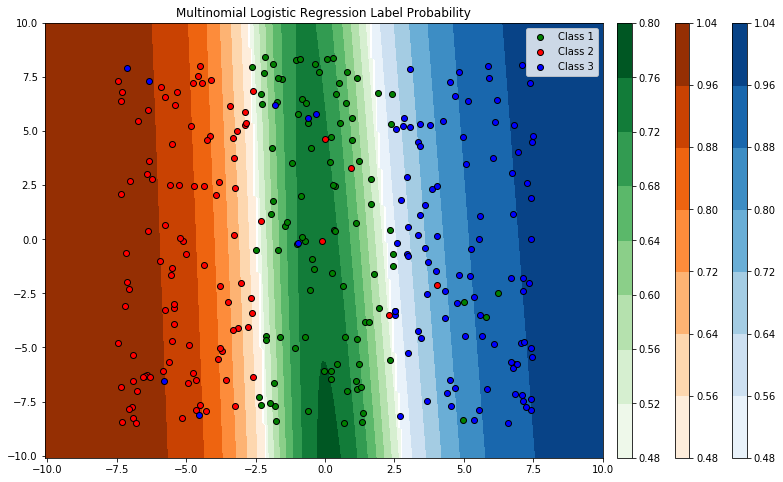

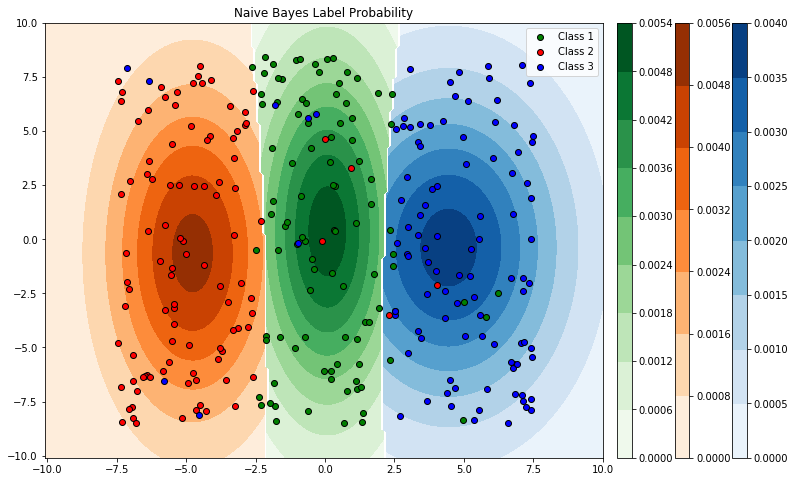

In [10]:
box = [-10, 10]

fig1, ax1 = contour_plot(lg_ovr_model, X, y, box=box)
ax1.set_title("Ovr Logistic Regression Label Probability")
fig1.savefig("./uniform_log_ovr.png")

fig2, ax2 = contour_plot(lg_multi_model, X, y, box=box)
ax2.set_title("Multinomial Logistic Regression Label Probability")
fig2.savefig("./uniform_log_multi.png")

fig3, ax3 = contour_plot(nb_model, X, y, box=box)
ax3.set_title("Naive Bayes Label Probability")
fig3.savefig("./uniform_naive.png")
plt.show()

In [ ]:
#######  Uncomment to verify against Sklearn Implementation ##########

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

sklearn_lg_ovr = LogisticRegression(penalty='none', multi_class='ovr', solver='saga')
sklearn_lg_ovr.fit(X, y)
y_pred = sklearn_lg_ovr.predict(X)
print("Ovr Logistic Accuracy = %f" % (np.sum(y_pred == y) / len(y)))

sklearn_lg_multi = LogisticRegression(penalty='none', multi_class='multinomial', solver='saga')
sklearn_lg_multi.fit(X, y)
y_pred = sklearn_lg_multi.predict(X)
print("Multinorm Logistic Accuracy = %f" % (np.sum(y_pred == y) / len(y)))

sklearn_nb = GaussianNB()
sklearn_nb.fit(X, y)
y_pred = sklearn_nb.predict(X)
print("Naive Bayes Accuracy = %f" % (np.sum(y_pred == y) / len(y)))


def contour_plot_sklearn(model, X_train, y_train, box=[-5, 15]):
    y_pred = model.predict(X_train)

    delta = 0.1
    x_grid = np.arange(box[0] - delta, box[1] + delta, delta)
    y_grid = np.arange(box[0] - delta, box[1] + delta, delta)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    r, c = X_grid.shape
    Xy_grid = np.stack((X_grid.reshape(-1), Y_grid.reshape(-1)), axis=-1)

    probs = model.predict_proba(Xy_grid)
    preds = np.argmax(probs, axis=-1)
    pred_grid = preds.reshape(r, c)
    # print("Largest prob:", np.max(probs))
    Z_grid = np.take_along_axis(probs, preds[:, np.newaxis], axis=1).reshape(r, c)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    cntrs = []

    colors=["Greens", "Oranges", "Blues"]
    scolors = ["g", "r", "b"]
    for i, class_ in enumerate(model.classes_):
        masked_Z = np.ma.array(Z_grid, mask = (pred_grid!=i))
        cntrs.append(ax.contourf(X_grid, Y_grid, masked_Z, cmap=plt.get_cmap(colors[i])))
        cax = fig.add_axes([ax.get_position().x1 + 0.02 + 0.08*i, ax.get_position().y0, 0.02, ax.get_position().height])
        fig.colorbar(cntrs[i], cax=cax)
    for i, class_ in enumerate(model.classes_):
        ax.scatter(X_train[y_train==class_, 0], X_train[y_train==class_, 1], c=scolors[i], lw=1, edgecolors='black', label="Class %i" % class_)
    ax.legend()
    return fig, ax


fig1, ax1 = contour_plot_sklearn(sklearn_lg_ovr, X, y)
ax1.set_title("Ovr Logistic Regression Label Probability")

fig2, ax2 = contour_plot_sklearn(sklearn_lg_multi, X, y)
ax2.set_title("Multinormial Logistic Regression Label Probability")

# Note: this is different from our visual because we did not normalize the probabilities
# which helped us seeing the class-wise distributions better
fig3, ax3 = contour_plot_sklearn(sklearn_nb, X, y)
ax3.set_title("Naive Bayes Label Probability")
plt.show()


## Check Against SKLEARN